# Julia Sets

The following is a quick introduction to Julia Sets

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [41]:
def julia(c, size=256, center=(0.0, 0.0), zoom=1.0, iters=256):
    x, y = np.meshgrid(
        np.linspace(-1, 1, size) / zoom + center[0],
        np.linspace(-1, 1, size) / zoom + center[1],
    )
    z = x + 1j * y
    im = np.zeros(z.shape)
    ix = np.ones(z.shape, dtype=bool)
    for i in range(iters):
        z[ix] = z[ix] ** 2 + c
        ix = np.abs(z) < 2
        im += ix
    return im

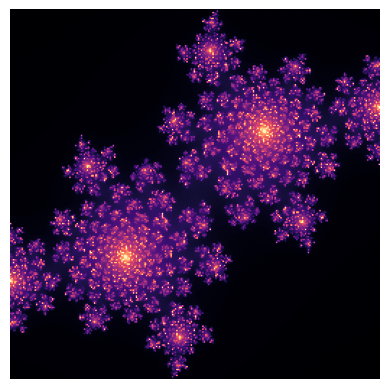

In [42]:
plt.imshow(julia(-0.4 + 0.6j), cmap="magma")
plt.axis(False);

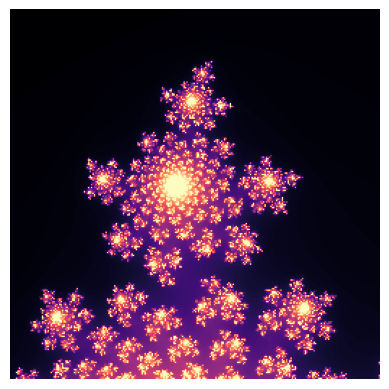

In [43]:
plt.imshow(julia(-0.4 + 0.6j, center=(0.34, -0.30), zoom=10000.0), cmap="magma")
plt.axis(False);

In [44]:
c = (
    -0.4 + 0.6j,
    -0.74543 + 0.11301j,
    -0.75 + 0.11j,
    -0.1 + 0.651j,
    -0.835 - 0.2321j,
    -0.70176 - 0.3842j,
)

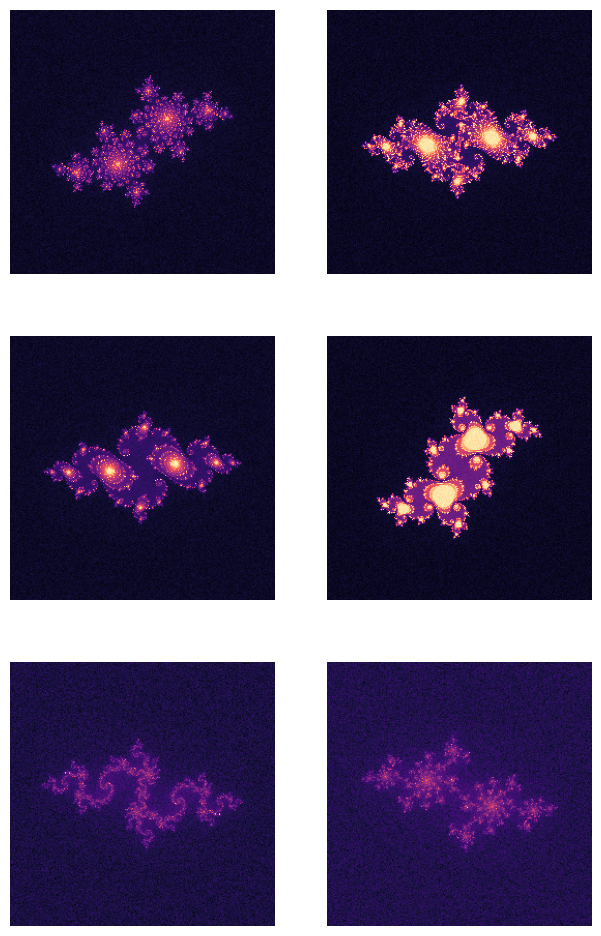

In [45]:
noise_level = 5.0

fig, ax = plt.subplots(3, 2, figsize=(7.5, 12))
for c_, a in zip(c, ax.flatten()):
    img = julia(c_, zoom=0.5)
    img += np.random.randn(*img.shape) * noise_level
    a.imshow(img, cmap="magma")
    a.axis(False)

# DataJoint Pipeline

Now let's build a data pipeline managing Julia sets and their analysis

In [46]:
from skimage import data
from skimage import filters

In [47]:
from skimage.morphology import disk
from skimage import restoration

In [48]:
import datajoint as dj

schema = dj.Schema("julia")

In [49]:
@schema
class JuliaSpec(dj.Manual):
    definition = """
    julia_spec : smallint 
    ---
    creal : float
    cimag : float
    size=256 : smallint
    center_real=0.0 : float 
    center_imag=0.0 : float
    zoom=1.0 : float
    noise_level=50 : float
    """

In [50]:
JuliaSpec.insert1(
    dict(
        julia_spec=0,
        creal=-0.4,
        cimag=0.6,
        center_real=0.34,
        center_imag=-0.30,
        zoom=10000.0,
        noise_level=50.0,
    )
)

In [51]:
# Insert additional Julia sets
JuliaSpec.insert(
    [
        dict(julia_spec=1, creal=-0.4, cimag=0.6, noise_level=50),
        dict(julia_spec=2, creal=-0.7453, cimag=0.11301, noise_level=50),
        dict(julia_spec=3, creal=-0.75, cimag=0.11, noise_level=50),
        dict(julia_spec=4, creal=-0.1, cimag=0.651, noise_level=50),
        dict(julia_spec=5, creal=-0.835, cimag=-0.2321, noise_level=50),
        dict(julia_spec=6, creal=-0.70176, cimag=-0.3842, noise_level=50)
    ]
)

In [52]:
@schema
class JuliaImage(dj.Computed):
    definition = """
    -> JuliaSpec 
    ---
    image : longblob
    """

    def make(self, key):
        spec = (JuliaSpec & key).fetch1()
        img = julia(
            spec["creal"] + 1j * spec["cimag"],
            size=spec["size"],
            center=(spec["center_real"], spec["center_imag"]),
            zoom=spec["zoom"],
        )
        img += np.random.randn(*img.shape) * spec["noise_level"]
        self.insert1(dict(key, image=img.astype(np.float32)))

In [53]:
JuliaImage.populate(display_progress=True)

JuliaImage: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


In [54]:
JuliaImage()

julia_spec,image
0,=BLOB=
1,=BLOB=
2,=BLOB=
3,=BLOB=
4,=BLOB=
5,=BLOB=
6,=BLOB=


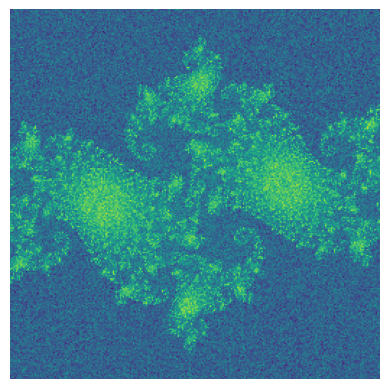

In [55]:
plt.imshow((JuliaImage & "julia_spec=2").fetch1("image"))
plt.axis(False);

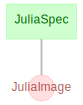

In [56]:
dj.Diagram(schema)

In [57]:
@schema
class DenoiseMethod(dj.Lookup):
    definition = """
    denoise_method : smallint
    ---
    method : varchar(16)
    params=null : blob
    """
    contents = (
        (0, "gaussian", dict(sigma=1.8)),
        (1, "median", dict(radius=3)),
        (2, "wavelet", {}),
        (3, "tv", dict(weight=20.0)),
    )

In [58]:
@schema
class JuliaDenoised(dj.Computed):
    definition = """
    -> JuliaImage
    -> DenoiseMethod
    ---
    denoised_image : longblob
    """

    def make(self, key):
        img = (JuliaImage & key).fetch1("image")
        method, params = (DenoiseMethod & key).fetch1("method", "params")

        if method == "gaussian":
            result = filters.gaussian(img, **params)
        elif method == "median":
            result = filters.median(img, disk(params["radius"]))
        elif method == "tv":
            result = restoration.denoise_tv_chambolle(img, **params)
        elif method == "wavelet":
            result = restoration.denoise_wavelet(img, **params)
        else:
            raise NotImplementedError
        self.insert1(dict(key, denoised_image=result))

In [59]:
JuliaDenoised.populate(display_progress=True)

JuliaDenoised: 100%|██████████| 28/28 [00:03<00:00,  7.54it/s]


In [60]:
JuliaDenoised()

julia_spec,denoise_method,denoised_image
0,0,=BLOB=
1,0,=BLOB=
2,0,=BLOB=
3,0,=BLOB=
4,0,=BLOB=
5,0,=BLOB=
6,0,=BLOB=
0,1,=BLOB=
1,1,=BLOB=
2,1,=BLOB=


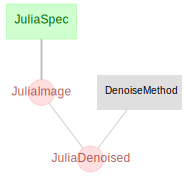

In [61]:
dj.Diagram(schema)

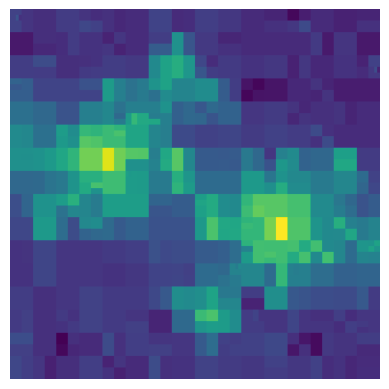

In [62]:
keys = JuliaDenoised.fetch("KEY")
img = ((JuliaDenoised & keys[20])).fetch1("denoised_image")
plt.imshow(img)
plt.axis(False);